In [28]:
import pandas as pd
import seaborn as sns

In [16]:
train = pd.read_csv('Titanic Data/train.csv')
test = pd.read_csv('Titanic Data/test.csv')

In [21]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [38]:
test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [39]:
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [27]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:xlabel='Age', ylabel='Count'>

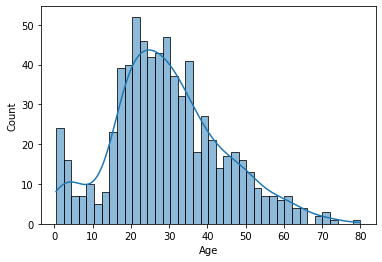

In [33]:
# histogram of age
sns.histplot(train['Age'], bins=40, kde=True)

In [34]:
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)

In [35]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [37]:
test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,417.000000,417.000000,417.000000,417.000000,417.000000
mean,2.263789,30.200103,0.448441,0.393285,35.627188
std,0.842077,12.562386,0.897568,0.982419,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,23.000000,0.000000,0.000000,7.895800
50%,3.000000,30.272590,0.000000,0.000000,14.454200
75%,3.000000,35.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200
